# Reddit Sentiment Analysis

In [5]:
%%capture
!pip install praw
!pip install wordcloud

In [2]:
import praw
from tqdm import notebook, tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import pandas as pd
import re
from openai import OpenAI
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
import unicodedata

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33649\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 0. Credentials

In [5]:
with open("credentials_reddit.json", 'r') as f:
    creds = json.load(f)

In [106]:
# creds

In [7]:
with open("credentials_openai.json", 'r') as f:
    creds_openai = json.load(f)

In [9]:
client = OpenAI(api_key=creds_openai["openai_key"])

In [10]:
user_agent = "Scraper 1.0 by /u/Agreeable_Ad1182"

reddit = praw.Reddit(client_id=creds['client_id'],
                     client_secret=creds['client_secret'],
                     user_agent= user_agent)

### 1. Quick look on commuties

In [11]:
communities = [
               "wallstreetbets",
               "finance",
               "options",
               "RobinHood",
               "StockMarket",
               "StocksAndTrading",
               "Superstonk",
               "WallStreetbetsELITE"]

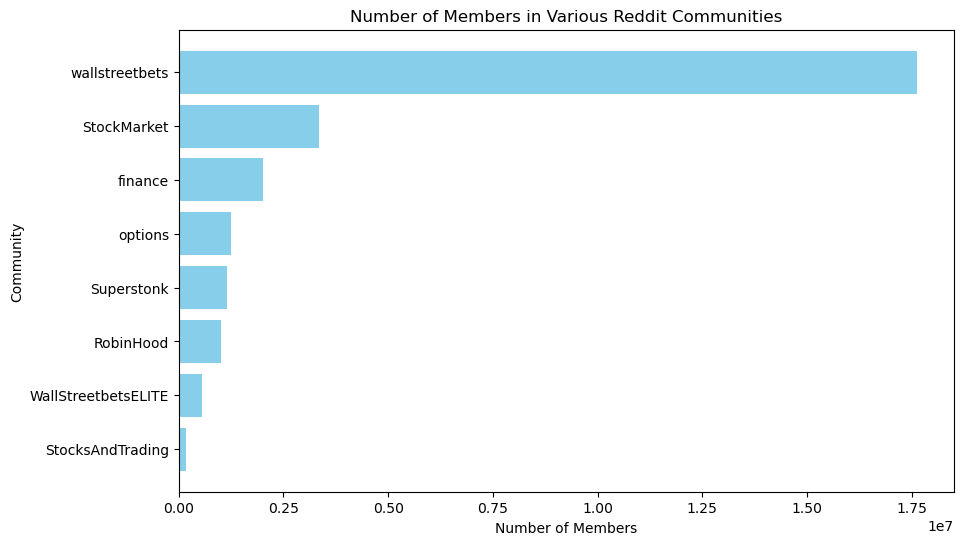

In [141]:
community_members = {}

for community in communities:
    subreddit = reddit.subreddit(community)
    community_members[community] = subreddit.subscribers
    
df_communities = pd.DataFrame(list(community_members.items()),
                              columns=['Community', 'Members'])

df_communities = df_communities.sort_values(by='Members', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df_communities['Community'], df_communities['Members'], color='skyblue')
plt.xlabel('Number of Members')
plt.ylabel('Community')
plt.title('Number of Members in Various Reddit Communities')
plt.gca().invert_yaxis()  
plt.show()

### 2. Queries

In [45]:
subreddit = reddit.subreddit("wallstreetbets")

flairs_found = set()

for post in subreddit.new(limit=1000):  
    if post.link_flair_text:
        flairs_found.add(post.link_flair_text)

print("Flairs trouvés :", flairs_found)


Flairs trouvés : {'News', 'YOLO', 'Shitpost', 'Meme', 'Loss', 'Daily Discussion', 'Weekend Discussion', 'Discussion', 'DD', 'Gain', 'Earnings Thread'}


In [62]:
def get_recent_reddit_posts(subreddit_name, limit=1000, nb_days = 100):

    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    yesterday = datetime.utcnow() - timedelta(days=nb_days)
    timestamp_yesterday = int(yesterday.timestamp())

    # Récupérer les posts les plus populaires du dernier jour
    for post in tqdm(subreddit.hot(limit=limit), desc="Récupération des posts"):
        if (post.link_flair_text.lower() in ["news", "dd", "gain", "loss", "discussion", "yolo"]):
            post.comments.replace_more(limit=0) 
            comments = [comment.body for comment in post.comments if hasattr(comment, 'body')]

            posts.append({
                'title': post.title,
                'selftext': post.selftext,
                'score': post.score,
                'flair': post.link_flair_text,
                'created_utc': datetime.utcfromtimestamp(post.created_utc),
                'comments': comments
            })
    
    return posts

In [63]:
posts = get_recent_reddit_posts("wallstreetbets", limit=1000)

Récupération des posts: 342it [04:16,  1.33it/s]


In [64]:
len(posts)

305

In [113]:
data = pd.DataFrame(posts)
data.head(20)

,title,selftext,score,flair,created_utc,comments
0,Prime Minister Justin Trudeau places 25 percen...,,37516,News,2025-02-02 02:22:26,[this is not /r/politics. nobody cares about y...
1,Puts on US carmakers and Calls on Korean and J...,https://www.wsj.com/economy/trade/canada-mexic...,246,Discussion,2025-02-02 17:08:04,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
2,"Despite Meeting With Nvidia CEO, Trump Sticks ...",,6159,News,2025-02-01 23:24:37,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
3,Trump starts tariffs tuesday confirmed signed ...,,11968,News,2025-02-01 19:40:18,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
4,My QQQ puts held during weekend. $20k worth.,Will Monday be bloody or pumpy? 🥭 about to dum...,49,Gain,2025-02-02 18:17:22,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
5,$20K Yolo,$20k yolo,108,YOLO,2025-02-02 13:52:53,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
6,Is that peak bubble?,Bitcoin FOMO has come for family finances.\n\n...,192,News,2025-02-02 08:35:04,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
7,How fucked am I,Should i sell at market open? Or let it ride o...,231,Loss,2025-02-02 05:21:02,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
8,Jim Cramer said DeepSeek’s threat to NVDA earn...,,1012,News,2025-02-01 20:39:29,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...
9,Puts on all the car makers…who’s ready to make...,Car makers are panicking over the huge tariffs...,466,Discussion,2025-02-01 20:26:15,[\n**User Report**| | | |\n:--|:--|:--|:--\n**...


In [114]:
texts = [f"{post['title']}. {post['selftext']}" for post in posts]

In [110]:
def clean_text(text, remove_urls=True, remove_mentions=True, 
                        remove_emojis=True):

    # Convertir en string et supprimer les NaN
    text = str(text)
    
    if remove_urls:
        text = re.sub(r'http\S+|www.\S+', '', text)
    
    if remove_mentions:
        text = re.sub(r'/u/[\w-]+|@\w+', '', text)
    

    if remove_emojis:
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = re.sub(r'[^\w\s$%À-ÿ]', ' ', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [115]:
clean_texts = [clean_text(text) for text in notebook.tqdm(texts)]

  0%|          | 0/305 [00:00<?, ?it/s]

### 3. HugingFace

In [116]:
classifier = pipeline("zero-shot-classification",model="sileod/deberta-v3-base-tasksource-nli")

In [119]:
%%time
candidate_labels = ['Positive', 'Negative', 'Neutral']
res_hugginFace = classifier(texts, candidate_labels)

CPU times: total: 1h 9min 3s
Wall time: 13min 21s


In [120]:
res_hugginFace[0]

{'sequence': 'Prime Minister Justin Trudeau places 25 percent tariffs on $106 billion worth of American products.. ',
 'labels': ['Negative', 'Positive', 'Neutral'],
 'scores': [0.7063149213790894, 0.16787774860858917, 0.1258072853088379]}

In [125]:
df_hug = pd.DataFrame.from_records(res_hugginFace)

df_hug['Score_Positive'] = 0.0
df_hug['Score_Negative'] = 0.0
df_hug['Score_Neutral'] = 0.0

for i, row in df_hug.iterrows():
    if 'labels' in row and 'scores' in row:
        score_dict = dict(zip(row['labels'], row['scores'])) 
        df_hug.at[i, 'Score_Positive'] = score_dict.get('Positive', 0.0)
        df_hug.at[i, 'Score_Negative'] = score_dict.get('Negative', 0.0)
        df_hug.at[i, 'Score_Neutral'] = score_dict.get('Neutral', 0.0)
    else:
        print(f"⚠️ Line {i} doesn't contain 'labels' or 'scores' !")

df_hug = df_hug[['sequence', 'Score_Positive', 'Score_Negative', 'Score_Neutral']]
df_hug.head(10)

,sequence,Score_Positive,Score_Negative,Score_Neutral
0,Prime Minister Justin Trudeau places 25 percen...,0.167878,0.706315,0.125807
1,Puts on US carmakers and Calls on Korean and J...,0.262912,0.643715,0.093373
2,"Despite Meeting With Nvidia CEO, Trump Sticks ...",0.172806,0.655645,0.171549
3,Trump starts tariffs tuesday confirmed signed ...,0.320637,0.395861,0.283502
4,My QQQ puts held during weekend. $20k worth.. ...,0.079187,0.632575,0.288238
5,$20K Yolo. $20k yolo,0.549272,0.239931,0.210798
6,Is that peak bubble?. Bitcoin FOMO has come fo...,0.310570,0.441549,0.247881
7,How fucked am I. Should i sell at market open?...,0.109571,0.453272,0.437157
8,Jim Cramer said DeepSeek’s threat to NVDA earn...,0.448393,0.178830,0.372778
9,Puts on all the car makers…who’s ready to make...,0.085887,0.807268,0.106846


In [130]:
df_hug['Flair'] = data['flair']
df_hug['Score_post'] = data["score"]

In [131]:
df_hug.to_csv('results_hugginface.csv')

In [140]:
df_hug

,sequence,Score_Positive,Score_Negative,Score_Neutral,Flair,Score_post
0,Prime Minister Justin Trudeau places 25 percen...,0.167878,0.706315,0.125807,News,37516
1,Puts on US carmakers and Calls on Korean and J...,0.262912,0.643715,0.093373,Discussion,246
2,"Despite Meeting With Nvidia CEO, Trump Sticks ...",0.172806,0.655645,0.171549,News,6159
3,Trump starts tariffs tuesday confirmed signed ...,0.320637,0.395861,0.283502,News,11968
4,My QQQ puts held during weekend. $20k worth.. ...,0.079187,0.632575,0.288238,Gain,49
...,...,...,...,...,...,...
300,Visa to the moon. On skibbdi this gonna make b...,0.714489,0.108724,0.176787,YOLO,3
301,Market reacting to new Chinese ai with less po...,0.570921,0.325804,0.103275,Loss,14
302,China is absolutely cooking and nobody outside...,0.480235,0.301804,0.217961,Discussion,3
303,Mortgage backed etf for safety MBB. I like MBB...,0.860338,0.034638,0.105023,Discussion,6


### 4. Data Analysis

In [8]:
df = pd.read_csv('results_hugginface.csv')

In [9]:
print("\n--- Statistiques descriptives ---")
print(df.describe())


--- Statistiques descriptives ---
       Unnamed: 0  Score_Positive  Score_Negative  Score_Neutral    Score_post
count  305.000000      305.000000      305.000000     305.000000    305.000000
mean   152.000000        0.450952        0.350057       0.198991   1091.534426
std     88.190136        0.262832        0.245195       0.099287   4081.699922
min      0.000000        0.017696        0.015621       0.023733      0.000000
25%     76.000000        0.232545        0.144837       0.120248     32.000000
50%    152.000000        0.443327        0.307936       0.195996     85.000000
75%    228.000000        0.667052        0.509113       0.268937    428.000000
max    304.000000        0.959573        0.942530       0.585783  46619.000000


In [135]:
print("\n--- Répartition par Flair ---")
print(df['Flair'].value_counts())


--- Répartition par Flair ---
Flair
Gain          88
YOLO          83
News          67
Discussion    39
Loss          20
DD             8
Name: count, dtype: int64


C:\Users\33649\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\33649\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\33649\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\33649\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

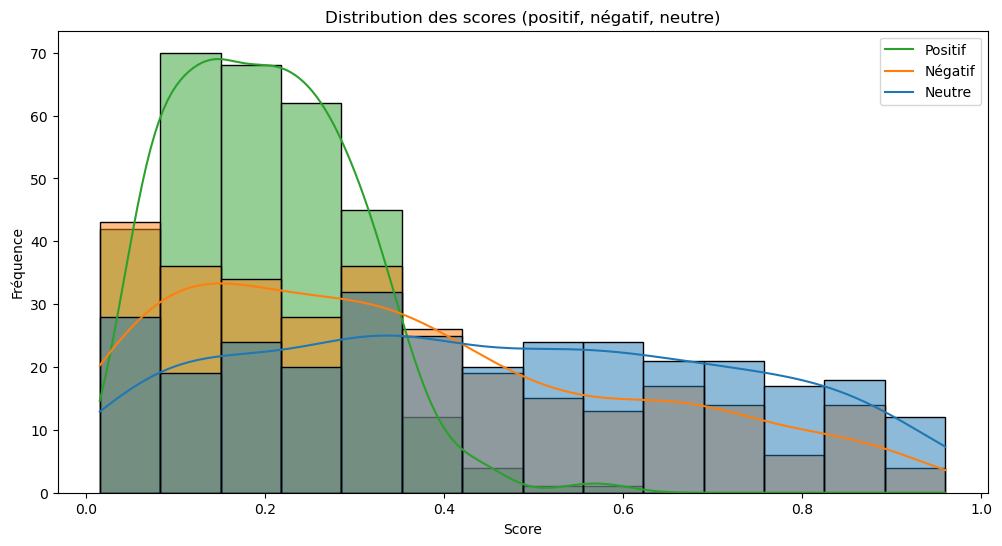

In [138]:
# Pour un aperçu global des distributions (positif, négatif, neutre)
plt.figure(figsize=(12, 6))
sns.histplot(data=df[['Score_Positive', 'Score_Negative', 'Score_Neutral']], 
             kde=True, 
             alpha=0.5)
plt.title("Distribution des scores (positif, négatif, neutre)")
plt.xlabel("Score")
plt.ylabel("Fréquence")
plt.legend(labels=["Positif", "Négatif", "Neutre"])
plt.show()

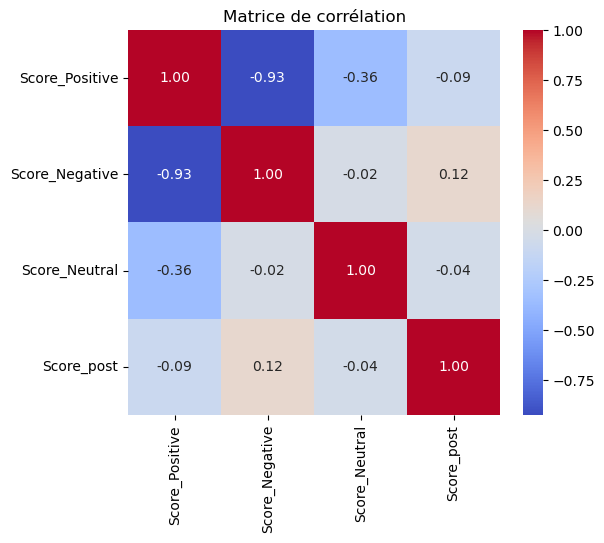

In [141]:
corr_cols = ['Score_Positive', 'Score_Negative', 'Score_Neutral', 'Score_post']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

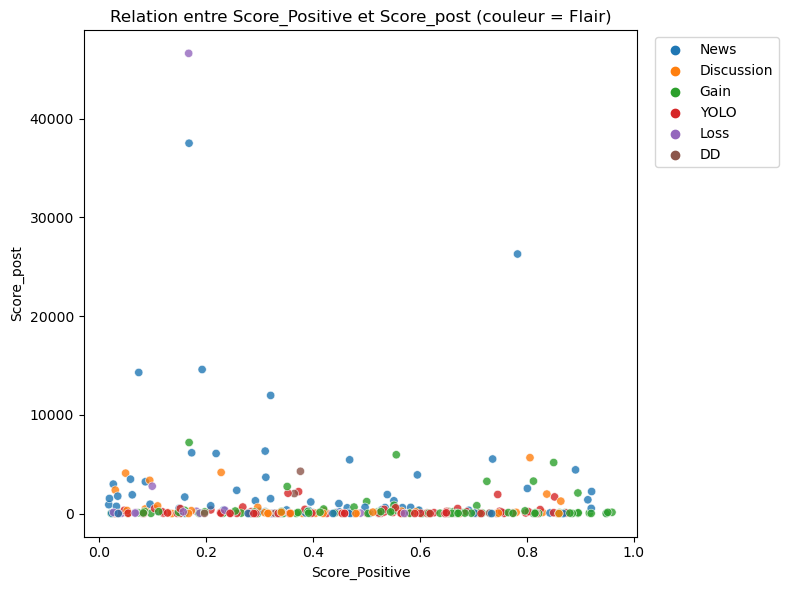

In [142]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, 
                x='Score_Positive', 
                y='Score_post', 
                hue='Flair',
                alpha=0.8)
plt.title("Relation entre Score_Positive et Score_post (couleur = Flair)")
plt.xlabel("Score_Positive")
plt.ylabel("Score_post")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


--- Moyenne des scores par Flair ---
            Score_Positive  Score_Negative  Score_Neutral   Score_post
Flair                                                                 
DD                0.399038        0.368204       0.232759   805.750000
Discussion        0.398476        0.399288       0.202236   702.512821
Gain              0.535835        0.292767       0.171398   460.363636
Loss              0.242625        0.536438       0.220937  2575.850000
News              0.413110        0.383459       0.203432  2843.059701
YOLO              0.471364        0.314043       0.214593   199.518072


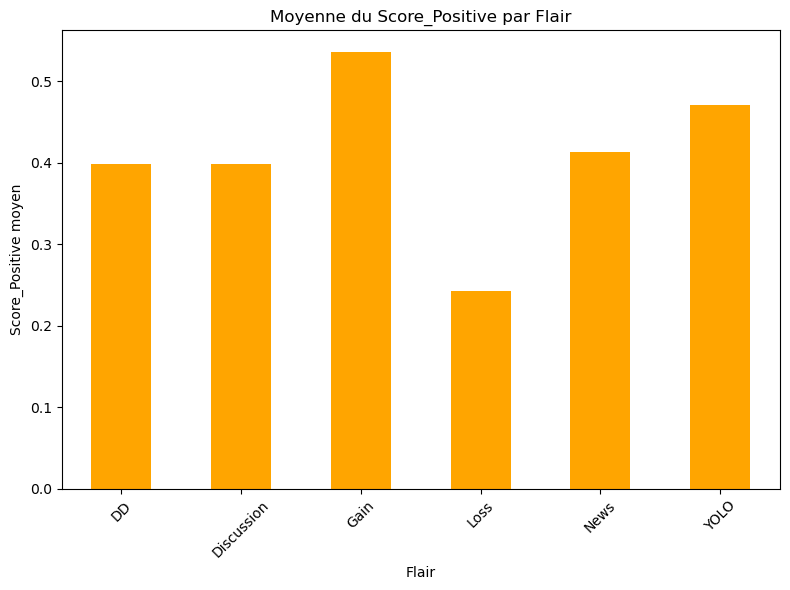

In [143]:
mean_scores_by_flair = df.groupby('Flair')[['Score_Positive', 'Score_Negative', 'Score_Neutral', 'Score_post']].mean()
print("\n--- Moyenne des scores par Flair ---")
print(mean_scores_by_flair)

plt.figure(figsize=(8, 6))
mean_scores_by_flair['Score_Positive'].plot(kind='bar', color='orange')
plt.title("Moyenne du Score_Positive par Flair")
plt.xlabel("Flair")
plt.ylabel("Score_Positive moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

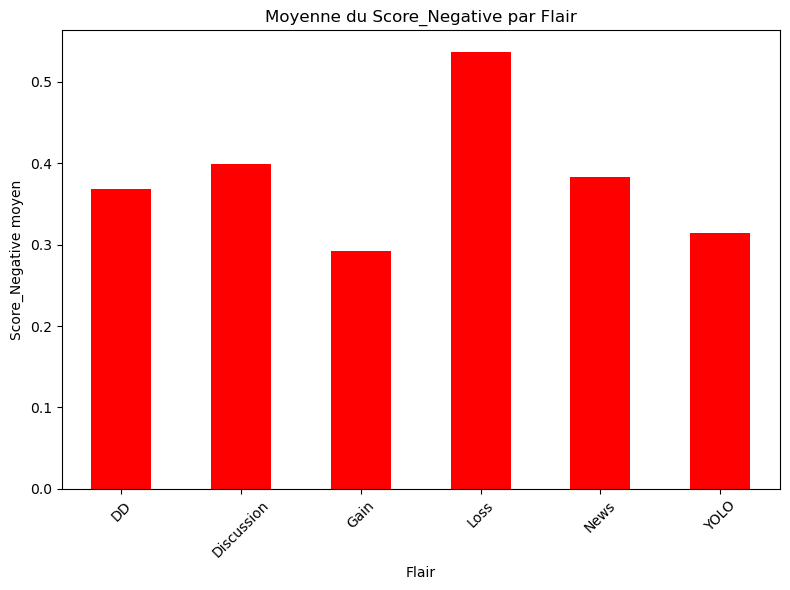

In [144]:
plt.figure(figsize=(8, 6))
mean_scores_by_flair['Score_Negative'].plot(kind='bar', color='red')
plt.title("Moyenne du Score_Negative par Flair")
plt.xlabel("Flair")
plt.ylabel("Score_Negative moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
def regex_tokenize_text(text, pattern=r'[^a-zA-Z0-9\$]+', lang='english'):
    sw = set(stopwords.words(lang))
#     sw.append('per')
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower()
    tokens = re.split(pattern, text)
    tokens = [tok for tok in tokens if tok]
    filtered_tokens = [tok for tok in tokens if tok not in sw and not tok.isdigit()]
    return filtered_tokens


df['tokens'] = df['sequence'].astype(str).apply(regex_tokenize_text)
print(df[['sequence','tokens']].head(20))

                                             sequence  \
0   Prime Minister Justin Trudeau places 25 percen...   
1   Puts on US carmakers and Calls on Korean and J...   
2   Despite Meeting With Nvidia CEO, Trump Sticks ...   
3   Trump starts tariffs tuesday confirmed signed ...   
4   My QQQ puts held during weekend. $20k worth.. ...   
5                                $20K Yolo. $20k yolo   
6   Is that peak bubble?. Bitcoin FOMO has come fo...   
7   How fucked am I. Should i sell at market open?...   
8   Jim Cramer said DeepSeek’s threat to NVDA earn...   
9   Puts on all the car makers…who’s ready to make...   
10  Monday.. Could be fun could be dumb. Hoping fo...   
11  Year of the Snake has the worst avg returns fo...   
12  YOLO Trade on DECK. Bought 2,718 shares at clo...   
13  12k -> 115k @ 22 yr old. Friend told me this i...   
14                          Who’s ready for Monday?.    
15  American Semiconductors should be ok on tariff...   
16  $800 -> $64,000 in 1 MONTH.

In [44]:
def most_common_ngrams(tokens, ngram, top = 20):
    n_grams = list(ngrams(tokens, ngram))
    ngrams_freq = Counter(n_grams)
    return ngrams_freq.most_common(20)

### Ngrams

#### ALL

In [45]:
all_tokens = [token for sous_liste in df['tokens'] for token in sous_liste]

In [95]:
print("20 most commons words in the corpus :")
most_common_ngrams(all_tokens, 1, top = 20)

20 most commons words in the corpus :


[(('ai',), 127),
 (('deepseek',), 88),
 (('nvidia',), 86),
 (('market',), 76),
 (('china',), 68),
 (('earnings',), 64),
 (('nvda',), 63),
 (('year',), 63),
 (('stock',), 61),
 (('could',), 54),
 (('puts',), 53),
 (('today',), 52),
 (('us',), 47),
 (('quantum',), 46),
 (('calls',), 44),
 (('like',), 44),
 (('new',), 44),
 (('yolo',), 42),
 (('chinese',), 40),
 (('price',), 40)]

In [96]:
print("20 most commons bigrams in the corpus :")
most_common_ngrams(all_tokens, 2, top = 20)

20 most commons bigrams in the corpus :


[(('quantum', 'computing'), 28),
 (('per', 'share'), 12),
 (('artificial', 'intelligence'), 11),
 (('open', 'source'), 10),
 (('nvidia', 'stock'), 9),
 (('price', 'target'), 9),
 (('nvda', 'calls'), 8),
 (('long', 'term'), 8),
 (('ai', 'model'), 8),
 (('real', 'estate'), 8),
 (('last', 'year'), 7),
 (('white', 'house'), 7),
 (('spy', 'puts'), 7),
 (('ai', 'models'), 7),
 (('gross', 'margin'), 7),
 (('earnings', 'call'), 6),
 (('upcoming', 'catalysts'), 6),
 (('stock', 'price'), 6),
 (('earnings', 'today'), 6),
 (('chinese', 'ai'), 6)]

In [97]:
print("20 most commons trigrams in the corpus :")
most_common_ngrams(all_tokens, 3, top = 20)

20 most commons trigrams in the corpus :


[(('eastman', 'business', 'park'), 5),
 (('chinese', 'artificial', 'intelligence'), 4),
 (('artificial', 'intelligence', 'startup'), 4),
 (('intelligence', 'startup', 'deepseek'), 4),
 (('quantum', 'computing', 'research'), 4),
 (('margin', 'est', 'bps'), 4),
 (('est', 'bps', 'yoy'), 4),
 (('target', 'price', '$18'), 4),
 (('year', 'year', 'increase'), 3),
 (('com', 'buy', 'hold'), 3),
 (('buy', 'hold', 'sell'), 3),
 (('ceo', 'jensen', 'huang'), 3),
 (('president', 'donald', 'trump'), 3),
 (('free', 'cash', 'flow'), 3),
 (('meta', 'open', 'source'), 3),
 (('yoy', 'gross', 'margin'), 3),
 (('gross', 'margin', 'est'), 3),
 (('$190', 'price', 'target'), 3),
 (('next', 'month', 'stock'), 3),
 (('month', 'stock', 'stabilized'), 3)]

In [52]:
def sentiment_category(row):
    if row['Score_Positive'] > row['Score_Negative']:
        return 'Positif'
    else:
        return 'Négatif'

df['Sentiment'] = df.apply(sentiment_category, axis=1)


df_positive = df[df['Sentiment'] == 'Positif']
tokens_positive = [token for sous_liste in df_positive['tokens'] for token in sous_liste]

df_negative = df[df['Sentiment'] == 'Négatif']
tokens_negative = [token for sous_liste in df_negative['tokens'] for token in sous_liste]

#### Positive

In [98]:
print("20 most commons words in the posts with positive sentiment :")
most_common_ngrams(tokens_positive, 1, top = 20)

20 most commons words in the posts with positive sentiment :


[(('ai',), 83),
 (('nvidia',), 53),
 (('earnings',), 51),
 (('deepseek',), 50),
 (('china',), 50),
 (('market',), 49),
 (('quantum',), 46),
 (('nvda',), 44),
 (('stock',), 43),
 (('today',), 38),
 (('yolo',), 37),
 (('kodak',), 37),
 (('could',), 36),
 (('year',), 35),
 (('new',), 34),
 (('computing',), 32),
 (('price',), 31),
 (('like',), 29),
 (('company',), 29),
 (('chinese',), 29)]

In [99]:
print("20 most commons bigrams in the posts with positive sentiment :")
most_common_ngrams(tokens_positive, 2, top = 20)

20 most commons bigrams in the posts with positive sentiment :


[(('quantum', 'computing'), 28),
 (('per', 'share'), 12),
 (('price', 'target'), 9),
 (('open', 'source'), 9),
 (('real', 'estate'), 7),
 (('upcoming', 'catalysts'), 6),
 (('spy', 'puts'), 6),
 (('gross', 'margin'), 6),
 (('earnings', 'report'), 5),
 (('year', 'year'), 5),
 (('investing', 'com'), 5),
 (('earnings', 'call'), 5),
 (('long', 'term'), 5),
 (('cash', 'flow'), 5),
 (('ai', 'model'), 5),
 (('earnings', 'today'), 5),
 (('financial', 'advice'), 5),
 (('type', 'certification'), 5),
 (('nvidia', 'stock'), 5),
 (('morgan', 'stanley'), 5)]

In [100]:
print("20 most commons trigrams in the posts with positive sentiment :")
most_common_ngrams(tokens_positive, 3, top = 20)

20 most commons trigrams in the posts with positive sentiment :


[(('eastman', 'business', 'park'), 5),
 (('quantum', 'computing', 'research'), 4),
 (('margin', 'est', 'bps'), 4),
 (('est', 'bps', 'yoy'), 4),
 (('target', 'price', '$18'), 4),
 (('year', 'year', 'increase'), 3),
 (('com', 'buy', 'hold'), 3),
 (('buy', 'hold', 'sell'), 3),
 (('ceo', 'jensen', 'huang'), 3),
 (('free', 'cash', 'flow'), 3),
 (('meta', 'open', 'source'), 3),
 (('yoy', 'gross', 'margin'), 3),
 (('gross', 'margin', 'est'), 3),
 (('$190', 'price', 'target'), 3),
 (('next', 'month', 'stock'), 3),
 (('month', 'stock', 'stabilized'), 3),
 (('stock', 'stabilized', '$7'), 3),
 (('stabilized', '$7', 'per'), 3),
 (('$7', 'per', 'share'), 3),
 (('case', '$', 'share'), 3)]

In [101]:
print("20 most commons words in the posts with negative sentiment:")
most_common_ngrams(tokens_negative, 1, top = 20)

20 most commons words in the posts with negative sentiment:


[(('ai',), 44),
 (('deepseek',), 38),
 (('nvidia',), 33),
 (('us',), 31),
 (('puts',), 29),
 (('year',), 28),
 (('market',), 27),
 (('bought',), 20),
 (('openai',), 20),
 (('nvda',), 19),
 (('calls',), 18),
 (('china',), 18),
 (('could',), 18),
 (('rate',), 18),
 (('stock',), 18),
 (('day',), 17),
 (('said',), 16),
 (('trump',), 15),
 (('like',), 15),
 (('interest',), 15)]

In [104]:
print("20 most commons bigrams in the posts with negative sentiment")
most_common_ngrams(tokens_negative, 2, top = 20)

20 most commons bigrams in the posts with negative sentiment


[(('artificial', 'intelligence'), 9),
 (('white', 'house'), 6),
 (('interest', 'rate'), 5),
 (('paper', 'hands'), 5),
 (('startup', 'deepseek'), 5),
 (('interest', 'rates'), 5),
 (('qqq', 'puts'), 4),
 (('mexico', 'canada'), 4),
 (('last', 'year'), 4),
 (('nvidia', 'stock'), 4),
 (('nvidia', 'corp'), 4),
 (('video', 'call'), 4),
 (('next', 'day'), 4),
 (('gen', 'ai'), 4),
 (('$1', 'trillion'), 4),
 (('chinese', 'artificial'), 4),
 (('intelligence', 'startup'), 4),
 (('technology', 'stocks'), 4),
 (('nvda', 'calls'), 4),
 (('diamond', 'hands'), 4)]

In [105]:
print("20 most commons trigrams in the posts with negative sentiment")
most_common_ngrams(tokens_negative, 3, top = 20)

20 most commons trigrams in the posts with negative sentiment


[(('chinese', 'artificial', 'intelligence'), 4),
 (('artificial', 'intelligence', 'startup'), 4),
 (('intelligence', 'startup', 'deepseek'), 4),
 (('president', 'donald', 'trump'), 3),
 (('started', 'trading', 'options'), 3),
 (('federal', 'open', 'market'), 2),
 (('open', 'market', 'committee'), 2),
 (('tariffs', 'mexico', 'canada'), 2),
 (('white', 'house', 'says'), 2),
 (('white', 'house', 'press'), 2),
 (('house', 'press', 'secretary'), 2),
 (('press', 'secretary', 'karoline'), 2),
 (('secretary', 'karoline', 'leavitt'), 2),
 (('people', 'familiar', 'matter'), 2),
 (('puts', 'disney', 'er'), 2),
 (('higher', 'tier', 'subscription'), 2),
 (('rates', 'steady', 'pausing'), 2),
 (('meta', 'platforms', 'inc'), 2),
 (('corp', 'oracle', 'corp'), 2),
 (('substantial', 'evidence', 'deepseek'), 2)]

### Wordcloud

In [94]:
def wordcloud(tokens, title = "Corpus global"):
    text_for_wordcloud = " ".join(tokens)
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='white', 
                          max_words=100).generate(text_for_wordcloud)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud - {title}", fontsize=16)
    plt.show()


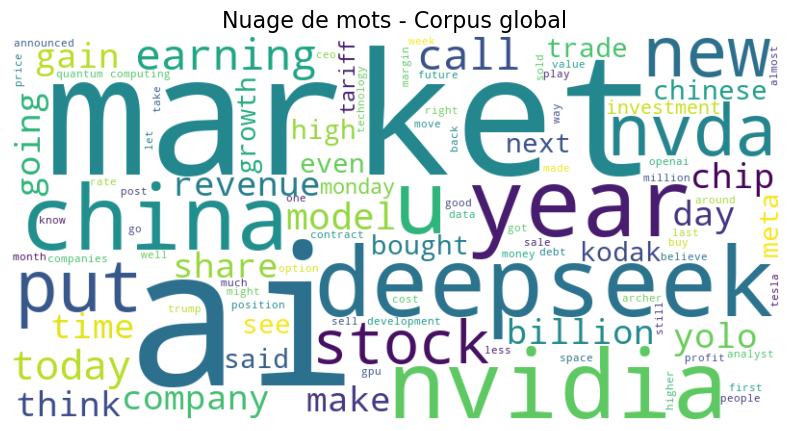

In [66]:
wordcloud(all_tokens)

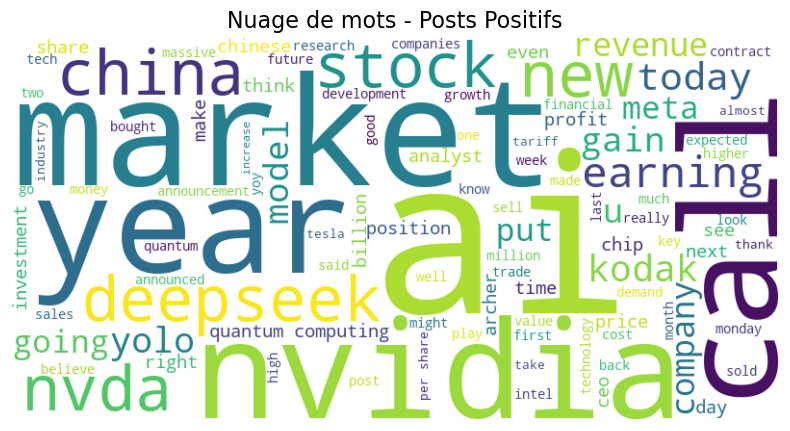

In [76]:
wordcloud(tokens_positive, "Posts Positifs")

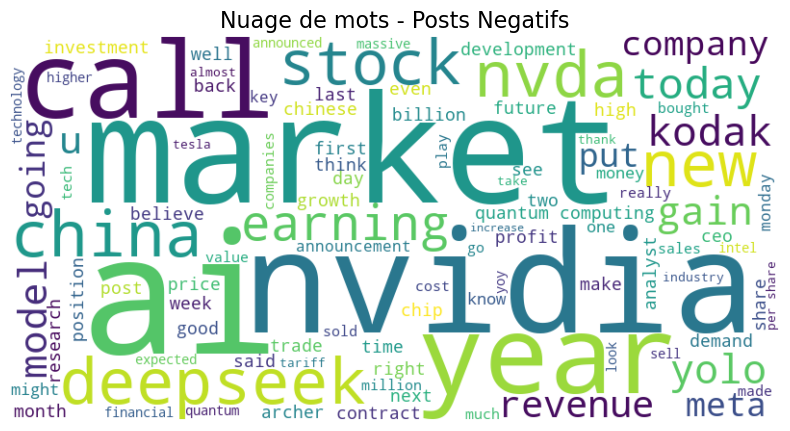

In [69]:
wordcloud(tokens_positive, "Posts Negatifs")

wordcloud not this impressive...

#### By flair and by sentiment

In [74]:
df['Flair'].unique()

array(['News', 'Discussion', 'Gain', 'YOLO', 'Loss', 'DD'], dtype=object)

- Flair : "Gain"

In [83]:
df_gain_positif = df[(df['Sentiment'] == 'Positif') & (df['Flair'] == 'Gain')]

,Unnamed: 0,sequence,Score_Positive,Score_Negative,Score_Neutral,Flair,Score_post,tokens,Sentiment
13,13,12k -> 115k @ 22 yr old. Friend told me this i...,0.850419,0.061508,0.088073,Gain,5170,"[12k, 115k, yr, old, friend, told, post, worth...",Positif
16,16,"$800 -> $64,000 in 1 MONTH. It says -10k cause...",0.500400,0.436745,0.062855,Gain,1213,"[$800, $64, month, says, 10k, cause, took, 10k...",Positif
21,21,Holy shit boys we did it. Sold spy calls at th...,0.725387,0.125988,0.148626,Gain,3266,"[holy, shit, boys, sold, spy, calls, top, boug...",Positif
28,28,Wow Almost 15k profit in less than 1 hour. Tru...,0.706496,0.154712,0.138792,Gain,801,"[wow, almost, 15k, profit, less, hour, trumpdump]",Positif
32,32,"I'm out, Tariffs saved me today 🐻. Downward sp...",0.596503,0.296554,0.106943,Gain,256,"[tariffs, saved, today, downward, spiral, reve...",Positif
...,...,...,...,...,...,...,...,...,...
276,276,Bear time.. Is your port ready?,0.545370,0.253948,0.200682,Gain,169,"[bear, time, port, ready]",Positif
281,281,It finally happened... My first 10 bagger.. Fi...,0.684350,0.137532,0.178119,Gain,47,"[finally, happened, first, bagger, figured, wo...",Positif
288,288,"Well I really needed that. I kid you not, I ca...",0.659919,0.153598,0.186483,Gain,28,"[well, really, needed, kid, caught, first, bla...",Positif
289,289,SPY Gain. This allows me to break even today lol,0.671586,0.028615,0.299799,Gain,34,"[spy, gain, allows, break, even, today, lol]",Positif


In [87]:
tokens_positive_gain = [token for sous_liste in df[(df['Sentiment'] == 'Positif') & (df['Flair'] == 'Gain')]['tokens']
                   for token in sous_liste]

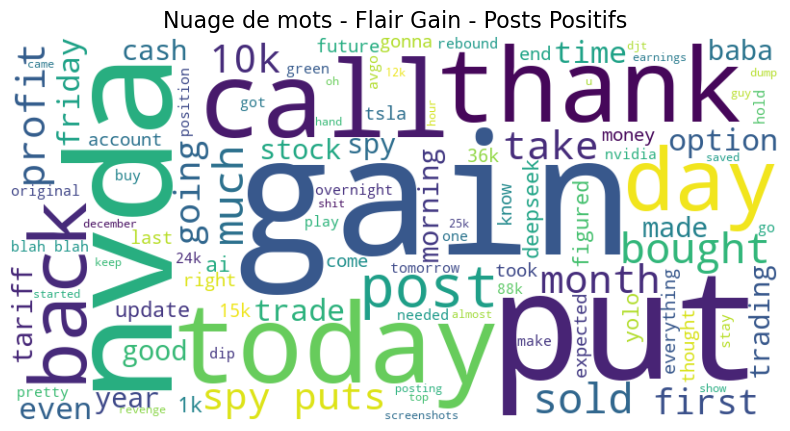

In [90]:
wordcloud(tokens_positive_gain, "Flair Gain - Posts Positifs")

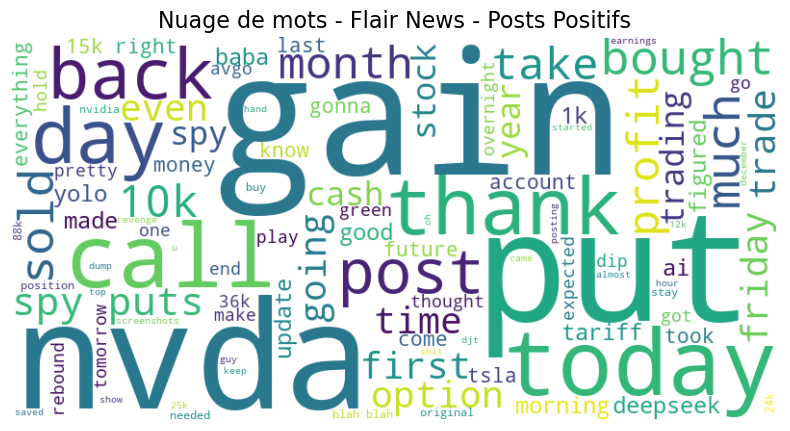

In [93]:
tokens_positive_yolo = [token for sous_liste in df[(df['Sentiment'] == 'Negatif') & (df['Flair'] == 'News')]['tokens']
                   for token in sous_liste]

wordcloud(tokens_positive_gain, "Flair News - Posts Negatifs")

Nothing special

In [107]:
import base64

# La chaîne que tu as donnée (sans le préfixe "CONTROLE_EFFECTUER: ")
encoded_string = "I64l8c7YNdyuub+7DYpm83hL+skDtyKXhPlVxQusmUI55MC0DNIq4E8UNv3ht2JaY1SZz15C0+QXutmixNv4/YptRMfdPYzi7f0MbTyrSzXJ5KJ3OYxrnCu6JBUHbtEF+0MjEE0noFIoJ9RRTio56DtIAuGvxqcKdtxbhvMCaojuhtuMwd5+687Hgboe1x1l3c2im1gKF6zvejNzfdJcD/GcHZsBeqWRfrZZBNGWTLlscNRYP8bZTvCtbVD9d8x3GRh1JIza0U0o2Fs78ewS6H5qsQYAvu967V1rmVLHWZxz6Dt6ZXVPenNvuIbdFv5vZ5iqia4NaoHIc2Daxe7xCw=="

def get_decoded_text(text_encoded):
    try:
        decoded_bytes = base64.b64decode(encoded_string)
        decoded_text = decoded_bytes.decode("utf-8", errors="ignore")  # Ignorer les erreurs de décodage
        decoded_text
    except Exception as e:
        decoded_text = str(e)

return decoded_text
decoded_text


'#%5ܮ\rfxK\x03"U\x0bB9\x0c*O\x146bZcT^B\x17٢mD=\x0cm<K5w9k+$\x15\x07n\x05C#\x10M\'R(\'QN*9;H\x02Ƨ\nv[\x02jی~ǁ\x1e\x1de͢X\n\x17z3s}\\\x0f\x1d\x01z~Y\x04іLlpX?NmPww\x19\x18u$M([;\x12~j\x06\x00z]kRYs;zeuOzso\x16og\rjs`\x0b'

### 5. Reading

In [72]:
for idx, row in df.iterrows():
    post = row['sequence']
    score_positive = row['Score_Positive']
    score_negative = row['Score_Negative']
    score_neutral = row['Score_Neutral']
    flair = row['Flair']
    score_post = row['Score_post']  

    print(f"Post #{idx+1}")
    print(f"Texte du post : {post}")
    print("\n")
    print(f"Score Positif : {score_positive}")
    print(f"Score Négatif : {score_negative}")
    print(f"Score Neutre  : {score_neutral}")
    print(f"Flair         : {flair}")
    print(f"Score_post    : {score_post}")
    print("-" * 120)

Post #1
Texte du post : Prime Minister Justin Trudeau places 25 percent tariffs on $106 billion worth of American products.. 


Score Positif : 0.1678777486085891
Score Négatif : 0.7063149213790894
Score Neutre  : 0.1258072853088379
Flair         : News
Score_post    : 37516
------------------------------------------------------------------------------------------------------------------------
Post #2
Texte du post : Puts on US carmakers and Calls on Korean and Japanese come Monday. https://www.wsj.com/economy/trade/canada-mexico-want-america-to-feel-the-pain-of-tariffs-too-f8119ccd?mod=mhp


American carmakers will be in deep trouble, but Japanese and Korean will have huge gains


Score Positif : 0.2629117667675018
Score Négatif : 0.6437153816223145
Score Neutre  : 0.0933728739619255
Flair         : Discussion
Score_post    : 246
------------------------------------------------------------------------------------------------------------------------
Post #3
Texte du post : Despite Meet